<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#EDA.-Анализ-качества-признаков" data-toc-modified-id="EDA.-Анализ-качества-признаков-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA. Анализ качества признаков</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Построение-модели-прогнозирования-оттока-клиентов" data-toc-modified-id="Построение-модели-прогнозирования-оттока-клиентов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Построение модели прогнозирования оттока клиентов</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Кластеризация-клиентов" data-toc-modified-id="Кластеризация-клиентов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Кластеризация клиентов</a></span><ul class="toc-item"><li><span><a href="#Кластеризация-алгоритмом-K-Mean" data-toc-modified-id="Кластеризация-алгоритмом-K-Mean-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Кластеризация алгоритмом K-Mean</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Стратегия удержания клиентов в сети фитнес-центров

## Описание проекта

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Используя датасет, который содержат исторические данные необходимо провести анализ и подготовить план действий по удержанию клиентов.

А именно:
1. Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;

2. Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;


3. Проанализировать основные признаки, наиболее сильно влияющие на отток;


4. Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    -  выделить целевые группы клиентов;
    -  предложить меры по снижению оттока;
    -  определить другие особенности взаимодействия с клиентами.

In [2]:
# загружаем библиотеки
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [4]:
# загружаем данные
gym = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv')

## EDA. Анализ качества признаков

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

**Данные клиента за предыдущий до проверки факта оттока месяц:**
 - 'gender' — пол;
 - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
 - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
 - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
 - 'Phone' — наличие контактного телефона;
 - 'Age' — возраст;
 - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
 
**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**
 - 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
 - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
 - 'Group_visits' — факт посещения групповых занятий;
 - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
 - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
 - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
 
**'Churn' — факт оттока в текущем месяце.**

In [6]:
# Функция для предварительного ознакомления с данными. 

def hello_data(data):
    
    ''' Выводит первые строки, 
                info, 
                уникальные значения
                и пропуски, если они есть '''
    
    columns = data.columns 
    display(data.head(10))
    display(data.info())
    lost_values = data.duplicated().sum()
   
    print(
        f'Явных дубликатов в данных: {lost_values}. Это {lost_values / len(data) * 100:.2f}% от всех значений.'
         )
    print()
        
    for column in columns: # для каждой колонки
        try:
            unique_value = (len(data[column].unique())) # считаем уникальные значения 
        except AssertionError:
            pass
        
        if data[column].isna().sum() != 0: # если в колонке есть пропуски
            print( f'Уникальных значений в колонке {column} - {unique_value}') #выводим количество уникальных значений
            persent = (data[column].isna().sum() / len(data[column]) * 100) # считаем сколько это в процентах и округляем методом "round"
            print('Пропущенных строк в колонке {} - {:.1f} %'.format(column, persent))
            print("_"*20)
        else: print( f'Уникальных значений в колонке {column} - {unique_value}') # если пропусков не нашли, то выводим количество уникальных значений  

# запускаем функцию
hello_data(gym)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

Явных дубликатов в данных: 0. Это 0.00% от всех значений.

Уникальных значений в колонке gender - 2
Уникальных значений в колонке Near_Location - 2
Уникальных значений в колонке Partner - 2
Уникальных значений в колонке Promo_friends - 2
Уникальных значений в колонке Phone - 2
Уникальных значений в колонке Contract_period - 3
Уникальных значений в колонке Group_visits - 2
Уникальных значений в колонке Age - 23
Уникальных значений в колонке Avg_additional_charges_total - 4000
Уникальных значений в колонке Month_to_end_contract - 12
Уникальных значений в колонке Lifetime - 29
Уникальных значений в колонке Avg_class_frequency_total - 3913
Уникальных значений в колонке Avg_class_frequency_current_month - 3820
Уникальных значений в колонке Churn - 2


В нашем датасете 4 тысячи наблюдений, 13 признаков и одна целевая переменная. Пропусков и дубликатов не обнаружено. Часть признаков  категориальная и принимает значения 0 или 1. В колонке "Contract_period" 3 значения  - 1, 6, 12. В колонке 'month_to_end_contract' тип float, заменим на int. Все названия колонок приведем к нижнему регистру. Изменим отображение вещественных чисел с точностью до сотых.

In [7]:
#переведем названия колонок в нижний регистр
gym.columns = gym.columns.str.lower()
# переведем тип данных в целочисленный
gym['month_to_end_contract'] = gym['month_to_end_contract'].astype(np.int64)
# поменяем отображение вещественных чисел с точностью до сотых
pd.options.display.float_format = '{:,.2f}'.format

In [8]:
# посмотрим на средние показатели признаков
gym.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


Изучив признаки, пришли к следующим выводам:

- мужчин и женщин примерно поровну(среднее 0,51).
- Большая часть клиентов живет рядом с фитнес-центром (среднее 0,84).
- Половина клиентов - сотрудники компаний-партнёров (среднее 0,48).
- Треть клиентов пришла по акции "Приведи друга" (среднее 0,3).
- Почти все клиенты оставляют номер своего телефона (среднее 0,9).
- Чаще всего клиенты берут абонемент на месяц. Здесь ориентируемся не на среднее, а на квартили, т.к. колонка содержит всего 3 варианта значений 1 месяц, 6 и 12 месяцев. Медианное значение - месяц, 75 квартиль - 6 месяцев.
- Групповые занятия посещают менее половины клиентов (среднее 0,41).
- Средний возраст клиентов 29 лет. Большинство в возрасте от 27 до 31 года.
- Медианная выручка от других услуг фитнес-центра: кафе, спорттовары, массажный салон- 136.22 у.е. на клиента. Имеет большой разброс от 68 до 210 у.е. (25 и 75 квартили), максимально 552,59 у.е.
- Медианное время с момента первого обращения - 3 месяца. Большинство клиентов с нами от 1 до 5 месяцев (25 и 75 квартили), максимально 31 месяц.
- Средняя частота посещений в неделю за все время с начала действия абонемента - 1,87. Большинство ходит 1-3 раза в неделю (25 и 75 квартили). Фанаты спорта - 6 раз в неделю. Есть и те, кто купил абонемент, но так и не пришел.
- Средняя частота посещений в неделю за предыдущий месяц - 1.76. Если сравнивать с показателем за всё время, то наблюдаем небольшое снижение показателя. Можно предположить, что клиенты, прежде чем нас покинуть, начинают реже посещать тренировки. Интересно будет глянуть на корреляцию с фактом оттока.
- Отток клиентов существенный (среднее 0,27)

Сгруппируем клиентов по факту оттока и посмотрим на средние значения признаков в двух группах — тех, кто ушел и тех, кто остался.

In [12]:
gym.groupby('churn').agg('mean').T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Заметна существенная разница в показателях. У тех, кто перестал посещать фитнес-центр практически все показатели ниже(хуже), чем у тех, кто остался.

Среди ушедших 23% живут не вблизи, 36% попали к нам по партнерской программе, только 18% пришли по приглашению друзей. Эти клиенты брали абонемент преимущественно на месяц, редко больше(среднее по длительности текущего действующего абонемента 1,73), вдвое реже посещали групповые тренировки, в среднем меньше занимались в неделю. И здесь тоже заметно снижение метрики общего среднего количества занятий в неделю (среднее 1,47) к среднему количеству занятий в неделю в последний месяц(среднее 1,04). К слову, у тех кто остался этот показател даже чуть вырос, с 2,02 до 2,03. Так что соотношение общего среднего  количества посещений в неделю к среднему за последний месяц можно использовать как индикатор сигнализирующий, что клиент вот-вот уйдет.

Впрочем, среди тех кто ушел,  lifetime в среднем меньше 1. Это означает, что большинство клиентов мы теряем сразу. Они берут пробный абонемент, но не возвращаются к нам за следующим.

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)и посмотрим более детально на различия.

Напишем функцию, которая определяет необходимое количество графиков для сабплота и отрисовывает график по каждому параметру:

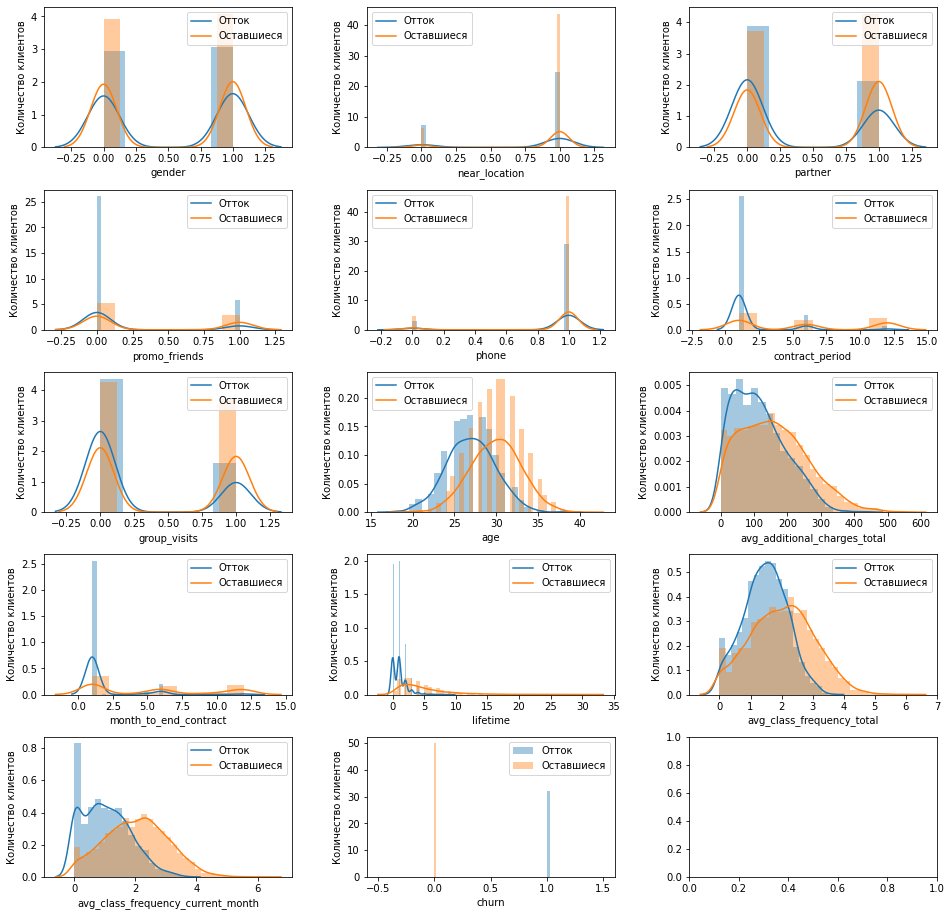

In [13]:
# сначала определяем количество строк для сабплота по количеству параметров. 
# Количество колонок фиксировано и = 3.
col_graph = 3
row_graph = len(gym.columns)

if row_graph % col_graph != 0:
    row_graph = row_graph // col_graph + 1
else:
    row_graph = row_graph/col_graph
    
# Пишем функцию для отрисовки графиков с одинаковыми параметрами
def draw_graph(i, col):
    plt.subplot(row_graph, col_graph, i) #  i - место графика на сабплоте
    # делим по факту оттока
    left = gym[gym['churn']==1]
    stayed = gym[gym['churn']==0]
    
    sns.distplot(left[col])
    sns.distplot(stayed[col])
    plt.legend(['Отток', 'Оставшиеся'])
    plt.xlabel(col)
    plt.ylabel('Количество клиентов')
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
# функция для перебора параметров
def create_graphs():
    axs = plt.subplots(row_graph, col_graph, figsize=(16,16))
    i = 1 # начинаем с 1 места на графике
    for column in gym.columns: # для каждой параметра
        draw_graph(i, column) # нарисуй график
        i += 1 
# теперь рисуем      
create_graphs()

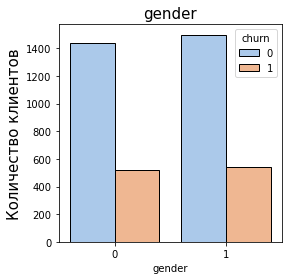

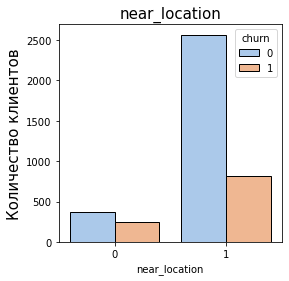

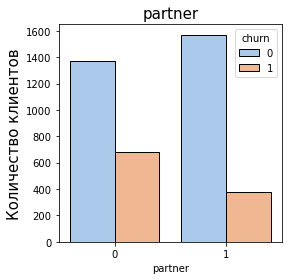

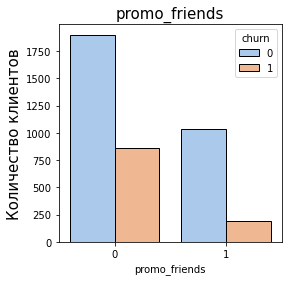

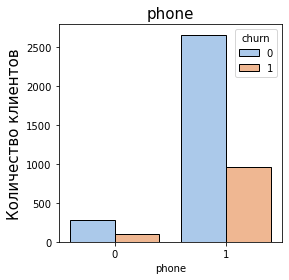

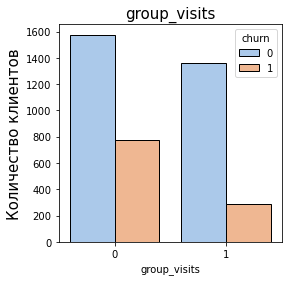

In [14]:
# для каждого бинарного признака из списка нарисуем график распределения
for binary_column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    
    plt.figure(figsize=(4, 4))
    sns.countplot(x = gym[binary_column], hue='churn', data=gym, palette=sns.color_palette("pastel"),  ec='black')
    
    plt.title(binary_column, fontsize=15)
    plt.ylabel("Количество клиентов", fontsize=15)
    
    plt.show()

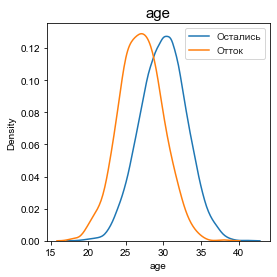

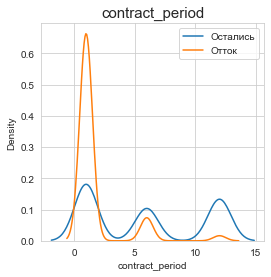

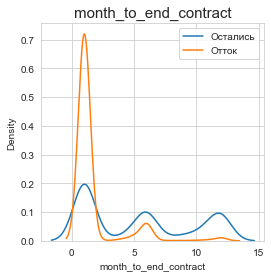

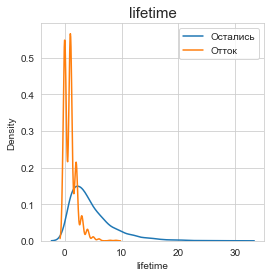

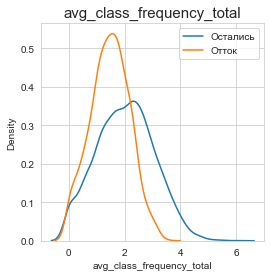

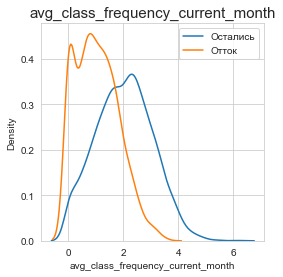

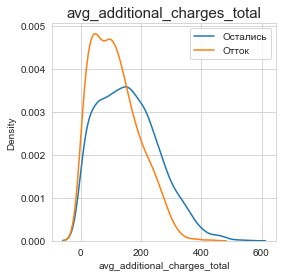

In [15]:
# для каждого небинарного признака из списка нарисуем график распределения
numeric_columns = ['age', 'contract_period', 'month_to_end_contract', 'lifetime',\
               'avg_class_frequency_total', 'avg_class_frequency_current_month',\
               'avg_additional_charges_total']
for column in numeric_columns:
    plt.figure(figsize=(4, 4))
    sns.kdeplot(gym.query('churn==0')[column], label = 'Остались')
    sns.kdeplot(gym.query('churn==1')[column], label = 'Отток')
     
    plt.title(column, fontsize=15) 
    sns.set_style('whitegrid')
    plt.legend()
    
    plt.show()

По lifetime видим подтверждение, что большую часть ушедших клиентов мы теряем практически сразу в первый месяц- два. Впрочем, и у тех, кто еще не ушел lifetime в пике приходится на 4-5 месяцев и не превышает 10. По графикам Avg_additional_charges_total и Avg_class_frequency_current_month заметно, как снижается частота тренировок в неделю со временем. Тоже плохой знак. Стоит рассмотреть причины происходящего. Как минимум поинтересоваться у клиентов как им сервис и что не понравилось. По графику 'Contract_period' видим самый большой отток среди купивших абонемент на 1 месяц, самый маленький отток у купивших абонемент на 12 месяцев. Здесь стоит посоветовать заняться удержанием клиентов, покупающих абонементы на 1 месяц. Возможно предложить им дополнительные скидки или услуги. По графику age видим, что тридцатилетние клиенты надежнее более молодых, а вот пол никак не влияет.

Теперь посмотрим  на распределения и взаимные корреляции между признаками и целевой переменной "Churn".

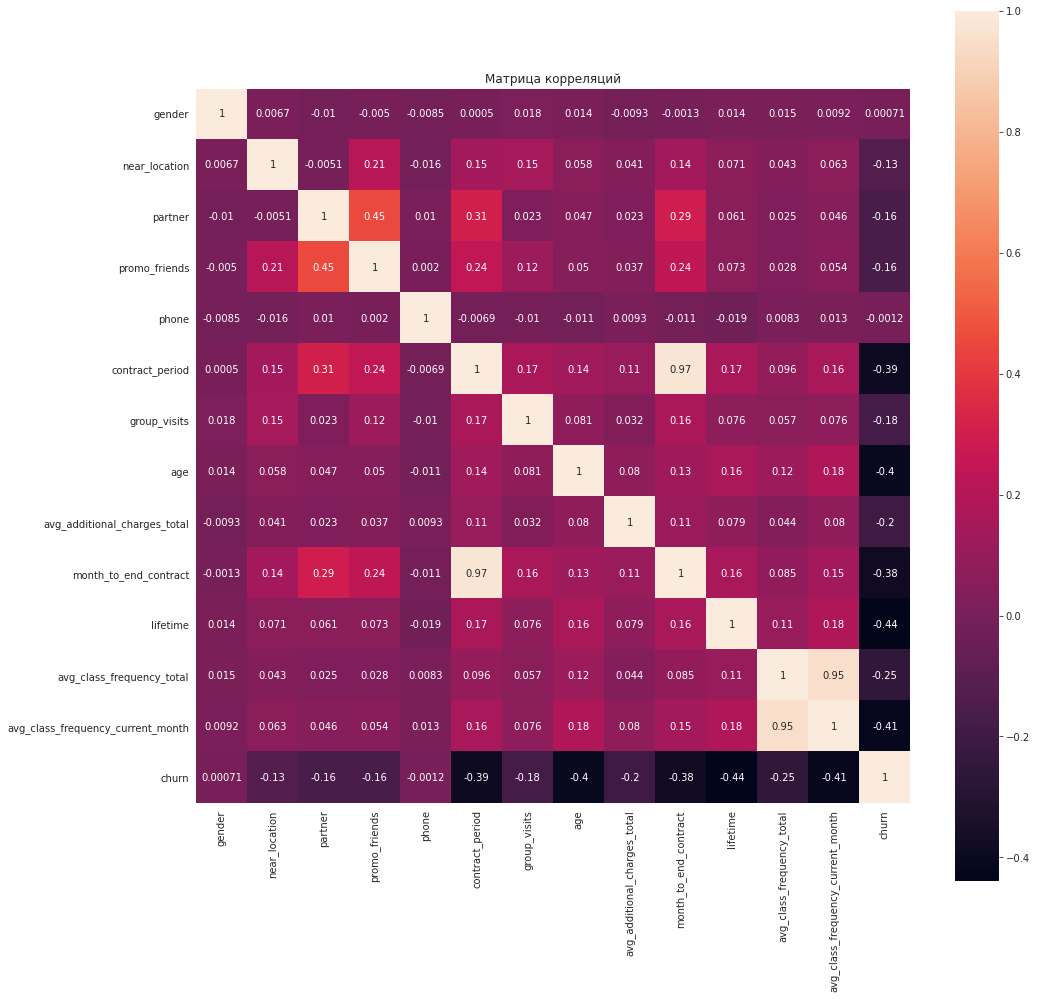

In [71]:
# строим матрицу корреляций
plt.figure(figsize=(16,16))
sns.heatmap(data = gym.corr(), annot=True, square=True)
plt.title('Матрица корреляций')
plt.show()

Есть пара мультиколлинеарных признаков: Avg_additional_charges_total и Avg_class_frequency_current_month- корреляция 0,95, 
Month_to_end_contract и Contract_period - корреляция 0,97. Выглядит логично. Срок до окончания текущего действующего абонемента явно зависит от срока купленного абонемента, а частота тренировок за предыдущие месяцы для постоянных клиентов вряд ли сильно изменится относительно текущего месяца. 

Целевая переменная Churn имеет отрицательную корреляцию практически со всеми признаками. Получается чем выше показатель, тем меньше отток. Так чем больше lifetime(корреляция: -0,44) или Contract_period(корреляция: -0,39), тем больше вероятность, что клент не уйдет. Неожидано видим существенную корреляцию с возрастом( -0,4). 

С целевой переменной не коррелируют gender и phone(значения близки к нулю) Получается факт оттока не зависит от пола и оставлял ли нам клиент контактный номер.

### Вывод

В датасете 4 тысячи наблюдений, 13 признаков и одна целевая переменная - Churn. Пропусков и дубликатов не обнаружено. В предобработке, где было необходимо, заменили тип float на int, все названия колонок привели к нижнему регистру, изменили отображение вещественных чисел с точностью до сотых.

Изучив признаки, пришли к следующим выводам:

- Отток клиентов существенный (среднее 0,27).
- Большую часть ушедших клиентов мы теряем практически сразу в первый месяц- два.
- Средняя частота посещений в неделю за последний месяц снизилась относительно общей средней. Надо работать с удержанием клиентов.

По графикам распределения и корреляции определили, что больше всего целевая переменная коррелирует с временем с момента первого обращения в фитнес-центр, длительностью текущего действующего абонемента (месяц, 6 месяцев, год), возрастом и частотой посещения тренировок. Есть зависимость от дальности проживания клиента, наличия скидок по партнерской программе и акции "приведи друга". 

## Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации пользователей, где целевой признак - факт оттока пользователя в следующем месяце. Для этого разобъем данные на обучающую и валидационную выборки функцией train_test_split(), обучим модель на train-выборке логистической регрессией и случайным лесом и оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели и решим какая модель показала себя лучше на основании метрик.

In [72]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop(columns=['churn'], axis=1)
y = gym['churn']

# разделим данные на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

display(X_train_st[:5])

#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test) 

array([[ 0.98265048,  0.42368158,  1.03175391, -0.65709005,  0.32751555,
         0.29763717,  1.19034383,  0.55025283, -0.92337193,  0.40835176,
        -0.19265756, -1.92902575, -1.67220815],
       [ 0.98265048,  0.42368158, -0.96922337, -0.65709005,  0.32751555,
         1.62230884,  1.19034383, -1.28583586,  0.16252804,  1.84694878,
        -0.46105294,  1.33328297,  1.25434216],
       [-1.01765584,  0.42368158, -0.96922337,  1.52186142,  0.32751555,
         0.29763717,  1.19034383,  0.24423805,  0.30907146, -0.07118058,
        -0.46105294, -0.76508827, -0.5382595 ],
       [-1.01765584,  0.42368158,  1.03175391,  1.52186142,  0.32751555,
         0.29763717,  1.19034383, -1.28583586, -0.99057964,  0.40835176,
        -0.99784369,  0.51992504,  0.70439819],
       [-1.01765584,  0.42368158, -0.96922337,  1.52186142, -3.05329013,
         1.62230884,  1.19034383, -0.06177673,  0.02573737,  1.60718261,
        -0.46105294, -0.29392092, -0.31938621]])

In [73]:
# функция для обучения модели и расчета метрик
def model_metrics(name, model):
    # обучаем
    model.fit(X_train_st, y_train)
    # делаем прогнозы
    y_pred = model.predict(X_test_st)
    y_proba = model.predict_proba(X_test_st)[:,1]
    # считаем метрики
    print('\nМодель {}. Метрики:'.format(name)) 
 
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score (y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score (y_test, y_pred)))
    print('F1: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, y_proba)))

    #  зададим алгоритм для нашей модели
model = LogisticRegression(random_state=0)
model_metrics('"Логистическая регрессия"', model)

model = RandomForestClassifier(random_state=0)
model_metrics('"Случайный лес"', model)


Модель "Логистическая регрессия". Метрики:
Accuracy: 0.94
Precision: 0.90
Recall: 0.85
F1: 0.87
ROC_AUC: 0.98

Модель "Случайный лес". Метрики:
Accuracy: 0.92
Precision: 0.88
Recall: 0.83
F1: 0.85
ROC_AUC: 0.97


### Вывод
Обе модели показали себя хорошо. Доля правильных ответов у обеих моделей выше 0,9.  По итогам всех трех измерений Логистическая регрессия показывает лучший результат.

## Кластеризация клиентов

Уберем целевой показатель с оттоком и проведем кластеризацию объектов (клиентов). Для этого:
- Стандартизируем данные.
- Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика предположим, какое количество кластеров можно выделить.
- Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 
- Посмотрим на средние значения признаков для кластеров.
- Построим распределения признаков для кластеров. 
- Для каждого полученного кластера посчитаем долю оттока и сделаем выводы.

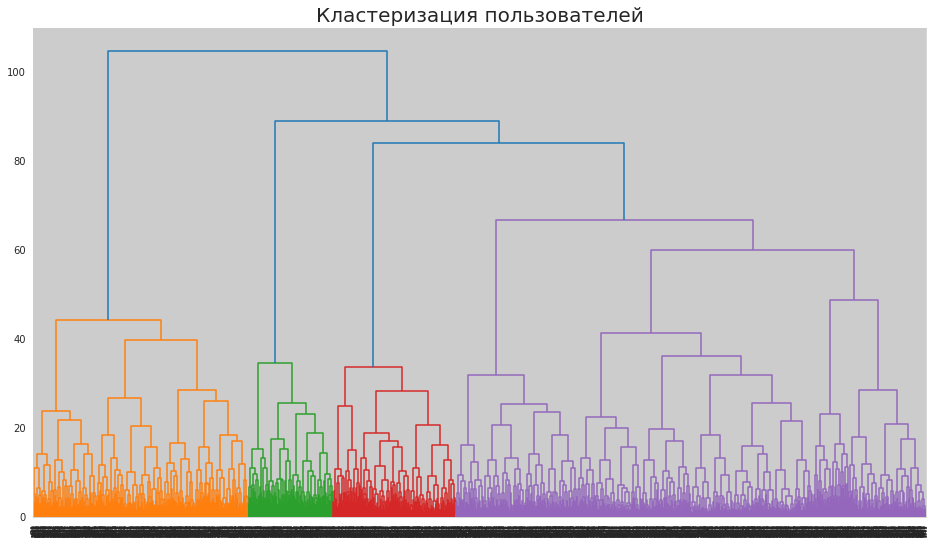

In [74]:
# убираем целевой покаатель
gym_drop_churn = gym.drop(['churn'], axis=1)

# стандртизируем 
sc = StandardScaler()
X_sc = sc.fit_transform(gym_drop_churn)


# строим матрицу расстояний
linked = linkage(X_sc, method = 'ward')

# рисуем дендрограмму
plt.figure(figsize=(16, 9))  
dendrogram(linked, orientation = 'top')
plt.title('Кластеризация пользователей', fontsize = 20)
plt.show()

Судя по цветовой схеме, можно разделить пользователей как минимум на 4 кластера, но фиолетовая ветка гораздо масштабнее, поэтому стоит увеличить число кластеров до 5-6. По условию задания примем число кластеров = 5.

###  Кластеризация алгоритмом K-Mean

In [58]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km =  KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(gym_drop_churn)

# сохраняем метки кластера в основной датасет
gym['cluster'] = labels

# Посмотрим на средние значения признаков для кластеров
gym.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.51,0.51,0.47,0.51,0.52
near_location,0.84,0.84,0.86,0.82,0.88
partner,0.45,0.50,0.52,0.49,0.51
promo_friends,0.28,0.32,0.33,0.29,0.35
phone,0.90,0.90,0.93,0.91,0.90
contract_period,4.30,4.76,5.82,4.20,5.40
group_visits,0.41,0.42,0.43,0.39,0.43
age,28.97,29.40,29.85,28.91,29.34
avg_additional_charges_total,105.93,174.87,356.48,35.60,250.98
month_to_end_contract,4.00,4.38,5.38,3.86,5.00


Типичные портреты клиентов. Отличия:
    
**Кластер 0** - отток 33%
- меньше посещают групповые тренировки (41%)
- предпочитают более короткие абонементы (4,3 мес)
- в среднем чуть моложе остальных(28,97)
- меньше тратят(105.93 у.е.)
- короткий lifetime (3,54 мес)
- реже занимаются (total 1,85 в неделю,  за предыдущий месяц 1.71в неделю)

**Кластер 1** - отток 23%
- половина из них пришла по партнерской программе (50%)
- меньше всего пришли по акции "приведи друга"(32%)
- меньше посещают групповые тренировки (42%)
- предпочитают длительные абонементы (4,76 мес)
- тратят ниже среднего (174.87 у.е.)
- короткий lifetime (3,75 мес)
- реже занимаются (total 1,9 в неделю,  за предыдущий месяц 1.79 в неделю)

**Кластер 2** - отток 4%
- Большинство живут или работают в районе, где находится фитнес-центр (86%)
- больше половины из них пришло по партнерской программе (52%)
- пришли по акции "приведи друга"(33%)
- чаще посещают групповые тренировки (43%)
- предпочитают длительные абонементы. Самый высокий показатель (5,82 мес)
- средний возраст выше (29.85)
- тратят больше всех (356.48 у.е.)
- самый длинный lifetime (4.42 мес)
- чаще других занимаются (total 2,02в неделю, за предыдущий месяц 2,01 в неделю)

**Кластер 3** - отток 35%
- Живут или работают в районе, где находится фитнес-центр только 82%
- меньше пришло по акции "приведи друга"(29%)
- хуже остальных посещают групповые тренировки (39%)
- предпочитают короткие абонементы. Самый низкий показатель (4,2 мес)
- моложе остальных (28.91)
- тратят меньше всех (35.60	у.е.)
- самый короткий lifetime (3,39 мес)
- чаще других занимаются (total 1,84,  за предыдущий месяц 1,69)

**Кластер 4** - отток 18%
- Живут или работают в районе, где находится фитнес-центр 86%
- больше половины из них пришло по партнерской программе (51%)
- пришли по акции "приведи друга"(35%). Самый высокий показатель
- чаще посещают групповые тренировки (43%)
- предпочитают длительные абонементы. Самый высокий показатель (5.40)
- средний возраст(28.91)
- приносят хороший доход (250.98 у.е.)
- lifetime (4.17 мес)
- занимаются не часто(total 1,9,  за предыдущий месяц 1,84)


По факту оттока у нас есть любимчик- кластер 2 (отток всего 4%). Да и в целом показатели в этом кластере лучше других: Средняя суммарная выручка от прочих услуг фитнес-центра самая высокая - 356.48 у.е., что выше среднего по всем клиентам фитнес-центра (75 квартиль 210 у.е.), клиенты из 2 кластера берут более длительные абонементы(5,82), имеют самый продолжительный lifetime(4.42), чаще других посещают тренировки в течение недели (2,01). В общем идеал лояльного клиента.

Также видим два кластера с высоим оттоком: кластер 0 (отток 33%) и кластер 3 (отток 35%). У них самый короткий lifetime (3.54 и 3,39 соотв.), они реже посещают тренировки в течение недели (1,85 и 1,84), здесь же замено снижение посещаемости в последний месяц (1,71 и 1,69 в неделю). При этом, можно отметить, что удаленность проживания для кластера 3 самая низкая(0,82), т.е. 18% клиентов живут далеко от фитнес-центра. Клиенты кластера 3 моложе, берут короткие абонементы, практически не пользуются дополнительными платными сервисами и быстрее других отваливаются.

Для наглядноти построим распределения по каждому признаку с разделением по кластерам. Начнем с бинарных признаков.

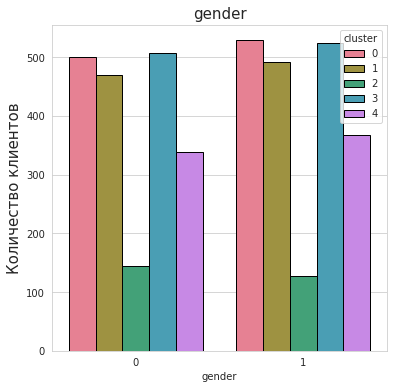

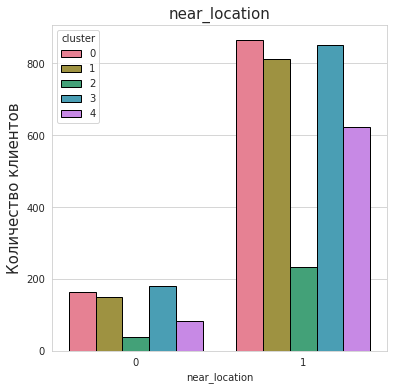

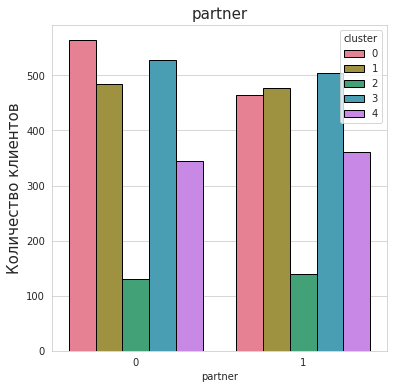

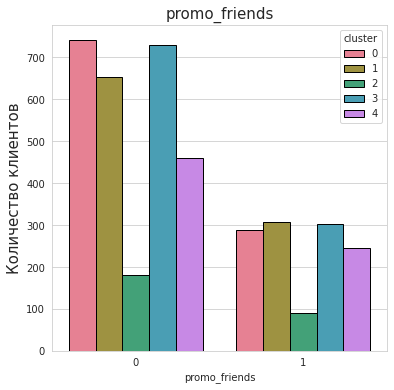

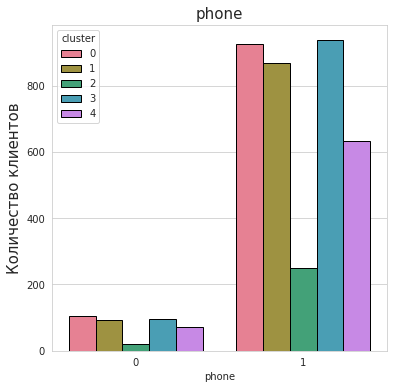

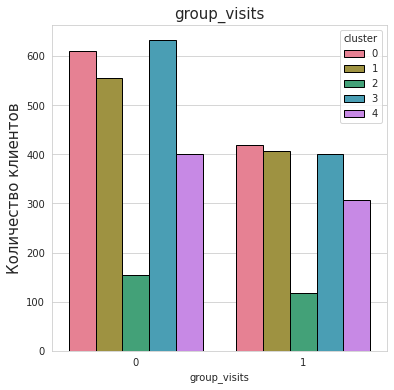

In [59]:
# для каждого бинарного признака из списка нарисуем график распределения
for binary_column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    
    plt.figure(figsize=(6, 6))
    sns.countplot(x = gym[binary_column], hue='cluster', data=gym, palette=sns.color_palette("husl", 5),  ec='black')
    
    plt.title(binary_column, fontsize=15)
    plt.ylabel("Количество клиентов", fontsize=15)
    
    plt.show()

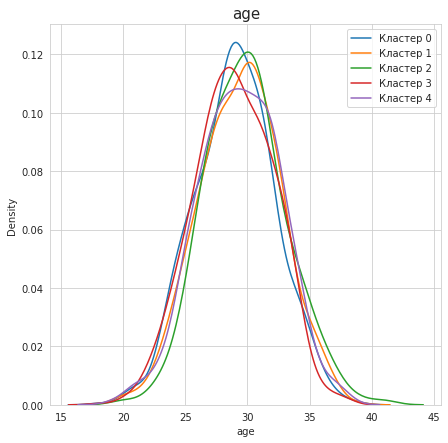

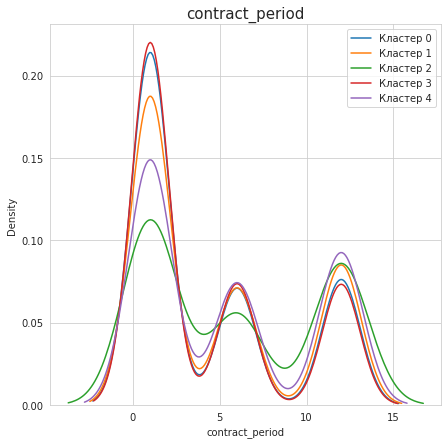

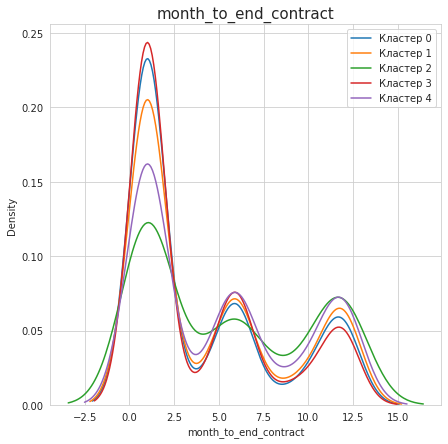

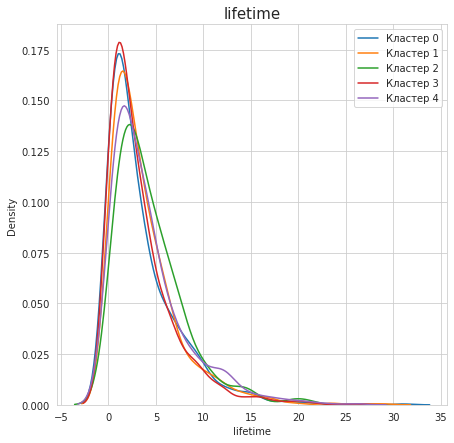

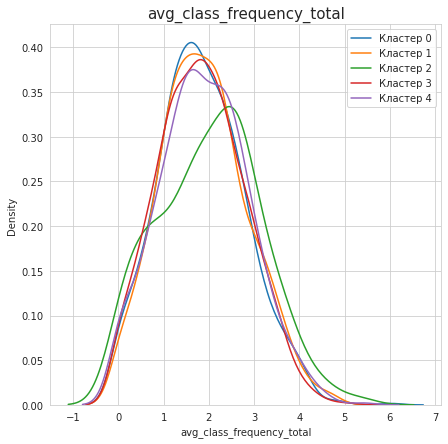

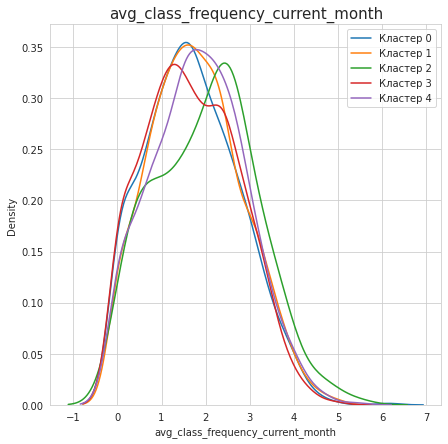

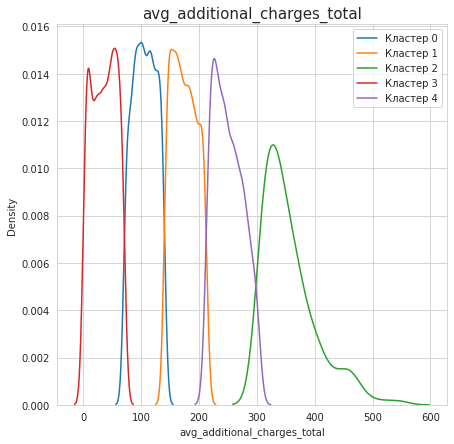

In [60]:
# для каждого небинарного признака из списка нарисуем график распределения
for column in numeric_columns:
    plt.figure(figsize=(7, 7))
    sns.kdeplot(gym.query('cluster==0')[column], label = 'Кластер 0')
    sns.kdeplot(gym.query('cluster==1')[column], label = 'Кластер 1')
    sns.kdeplot(gym.query('cluster==2')[column], label = 'Кластер 2')
    sns.kdeplot(gym.query('cluster==3')[column], label = 'Кластер 3')
    sns.kdeplot(gym.query('cluster==4')[column], label = 'Кластер 4')
    
    plt.title(column, fontsize=15) 
    sns.set_style('whitegrid')
    plt.legend()
    
    plt.show()

In [61]:
#посмотрим еще раз средние значения оттока в кластерах
gym.groupby('cluster').agg({'churn':'mean'}).sort_values(by='churn', ascending=False)

,churn
cluster,
3,0.35
0,0.33
1,0.23
4,0.18
2,0.04


Судя по последнему графику 'Avg_additional_charges_total', модель предпочла делить наших клиентов по суммарной выручке от других услуг фитнес-центра. Области практически не пересекаются. В остальном предварительные выводы по средним показателям подтверждаюся графиками. Кластер 2 ведет себя лучше остальных. Кластеры 0 и 3 соперничают между собой на звание худшего. 



## Вывод 



В датасете, предоставленном фитнес-центром 4 тысячи наблюдений, 13 признаков и одна целевая переменная - Churn. 

Изучив признаки, пришли к следующим выводам:

Отток клиентов существенный -27%.
Большую часть ушедших клиентов мы теряем практически сразу в первый месяц- два, у них короткие пробные абонементы.
Средняя частота посещений в неделю за последний месяц снизилась относительно общей средней. Lifetime в подавляющем большинстве не превышает 10 месяцев, при среднем 4,71 месяца. За полгода на всю жизнь не подкачаешься, поддержание хорошей физической формы - непрерывный процесс. Надо работать с удержанием клиентов, выявлять причины по которым клиенты теряют интерес к фитнес-центру, возможно провести анкетирование на удовлетворенность клиентов сервисом и пересмотреть систему ценообразования.

Построив модель кластеризации получили 5 типажей клиентов. Наиболее яркие Кластер 2 и Кластер 3, по сути они являютя антогонистами. Клиенты кластера 2 в среднем старше, обеспеченней, чаще других живут или работают по близости, скорее всего пришли к нам по партнерской программе или за компанию с друзьями, чаще ходят на групповые тренировки и чаще тренируются. У кластера 3 всё с точностью до наоборот: они моложе, дальше живут, берут короткие абонементы и реже тренируются, их меньше пришло в рамках акций и они практически не пользуются дополнительными платными услугами.

Для кластера 3 разумно разработать систему скидок на продление абонемента. Скажем, пролонгировать действующий абонемент с возрастающей скидкой к сроку. Учитывая, что большая часть клиентов тихо отваливается через 1-2 месяца, задача поднять интерес к более длительным абонементам. Это же касается и других кластеров. Помним про отрицательную корреляцию - чем выше метрика, тем ниже отток. В целом, нужно стараться поднять метрики до уровня Кластера 2:

- расширить партнерские программы, предпочтительно для работающих неподалеку,
- Продвигать групповые тренировки,
- следить за количеством тренировок в неделю и поощрять системность  и повышение частоты тренировок. 
- продвигать длительные абонементы и делать бонусы покупающим следующий длительный абонемент. Тем самым увеличивать общий lifetime клиента.




